<a href="https://colab.research.google.com/github/KValim/Projetcs/blob/main/Utilities/Time_series_Forecasting_in_Python_%26_R%2C_Part_2_(Forecasting_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series Forecasting in Python & R, Part 2 (Forecasting )
> In the second part of this blog series on forecasting I discuss forecasting steps, evaluation of forecasting methods, model selection, combinining models for robust and accurate forecasting and forecast uncertainty.  

- toc: true 
- badges: true
- comments: true
- categories: [forecasting,R,Python,rpy2,altair, fbprophet, ensemble_forecast, uncertainty, simulation]
- hide: false

## Overview

In Part 1, I did exploratory data analysis of sales time series of a French retailer. In this blog I will apply various time series models in Python and R to forecast sales for the next 4 quarters. The forecasting methods I will cover are:
   * Seasonal Naive 
   * Triple Exponential Smoothing (Holt Winter's)
   * ETS (State Space Error Trend Seasonality)
   * SARIMA
   * Facebook Prohet
   * Ensemble Forecast

For each of these models, I will provide a short description for intuitive understanding of these methods and give references for more academic explanation. For any forecasting model, the general steps are as below.

### Forecasting Steps

   1. EDA
   2. Forecast on test set
   3. Evaluate the forecast
       - Use appropriate evaluation metric (%MAPE, RMSE, AIC)
       - Plot the forecast against train and test data set
   4. Check residuals. 
       - Plot residuals, plot ACF/PACF and Q/Q plots
       - Conditions A, B below are essential and C,D are useful. Residuals should be:
            1. Uncorrelated
            2. Have zero (or close to zero) mean
            3. Constant variance
            4. Normally distributed 
            
       - First two ensure that there is no more information that can be extracted from the data, while the bottom two keep the variability in the point forecast narrow
   5. Select model(s)
       - Forecast future series
       - Prediction Interval
       
### Evaluation Metric

We evaluate the forecasting model by comparing the fitted & predicted values against the actual values in training and test sets. Note that residuals are the difference between training data and fitted values, while forecast error is the difference between test data and predicted values. We use residuals to check performance of the model while errors for checking accuracy/uncertainty of the future forecast.

As a general rule, if the data has no outliers RMSE (Root Mean Square Error) is a good metric to use. %MAPE (Mean Absolute Percentage Error) provides a more inutitive understanding as it is expressed in percentage. We do not use %MAPE if the series is intermittent to avoid division by zero. Note that both these measures are not scale independent but to keep things simple I will use RSME and MAPE. 


![Evaluation Metric](https://raw.githubusercontent.com/pawarbi/blog/master/images/emetric.JPG "Evaluation Metric")

#### Importing libraries


In [33]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
#collapse-hide
#Author: Sandeep Pawar
#Version: 1.0
#Date Mar 27, 2020

import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
pd.plotting.register_matplotlib_converters()
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb
from itertools import combinations

import prophet as Prophet


#library to use R in Python 
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
 


import warnings
warnings.filterwarnings("ignore")
np.random.seed(786)





#### Library versions

In [36]:
#Printing library versions

print('Pandas:', pd.__version__)
print('Statsmodels:', sm.__version__)
print('Scipy:', scipy.__version__)
print('Rpy2:', rpy2.__version__)
print('Numpy:', np.__version__)

Pandas: 1.3.5
Statsmodels: 0.13.5
Scipy: 1.7.3
Rpy2: 3.5.5
Numpy: 1.21.6


#### Various functions used 

Below are some of the custom functions I wrote for forecast accuracy, gridsearching, residual diagnostics.

In [37]:
def MAPE(y_true, y_pred): 
    """
    %Error compares true value with predicted value. Lower the better. Use this along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def HWGrid(train, test, seasonal_periods):
    """
    Author: Sandeep Pawar twitter: @PawarBI
    Functions returns a dataframe with parameters of the Holt-Winter's method and corresponding train & test evaluation scores. 
    It also does a quick check of the residuals using Ljung-Box test and Shapiro test for normality. 
    Residuals must be uncorrelated. 
    
    train: (pandas series)
        -  Training data
        
    test: (pandas series)
        -  Test data
    
    Seasonal_periods: int
        - No of seasonas in the time period. e.g. 4 for Quarterly, 12 for Monthly, 52 for Weekly data
        
    """


    trend      = ['add','mul']
    seasonal   = ['add','mul']
    damped     = [False, True]
    use_boxcox = [False, True, 'log']

    params = itertools.product(trend,seasonal,damped,use_boxcox)

    result_df = pd.DataFrame(columns=['Trend', 'Seasonal', 'Damped', 'BoxCox','AICc Train',  
                                      '%MAPE_Train', 'RMSE_Train', '%MAPE_Test', 
                                      'RMSE_Test', "Resid_LJ", "Resid_Norm","Resid_mean" ])
    
    
    for trend,seasonal,damped,use_boxcox in params:
    
            model = ExponentialSmoothing(train, 
                                     trend=trend,
                                     damped=damped,
                                     seasonal=seasonal,
                                     seasonal_periods=seasonal_periods).fit(use_boxcox=use_boxcox)
    
    
            
            mape1=MAPE(train,model.fittedvalues) 
            rmse1=rmse(train,model.fittedvalues)

            mape2=MAPE(test,model.forecast(len(test))) 
            rmse2=rmse(test,model.forecast(len(test)))

            aicc1 = model.aicc.round(1)

               
    
            lj_p_val = np.mean(ljung(x=model.resid, lags=10)[1])
            norm_p_val =  jb(model.resid)[1]#shapiro(model.resid)[1]
    
            lj = "Uncorrelated" if lj_p_val > 0.05 else "Correlated"
            norm = "Normal" if norm_p_val > 0.05 else "Non-Normal"
            
    
            result_df = result_df.append({'Trend':trend       ,
                              'Seasonal': seasonal            ,
                              'Damped':damped                 ,
                              'BoxCox':use_boxcox             ,
                              '%MAPE_Train':np.round(mape1,2) ,
                              'RMSE_Train':np.round(rmse1,1)  ,
                              'AICc Train':aicc1              ,
                              '%MAPE_Test':np.round(mape2,2)  ,
                              'RMSE_Test':np.round(rmse2,1)   ,
                              'Resid_LJ' :lj                  ,
                              'Resid_Norm':norm               ,
                              'Resid_mean':np.round(model.resid.mean(),1)} , ignore_index=True, sort=False)
    
    
    return result_df.sort_values(by=["RMSE_Test", "%MAPE_Test","RMSE_Train","%MAPE_Train"]).style.format({"%MAPE_Train": "{:20,.2f}%", "%MAPE_Test": "{:20,.2f}%"}).highlight_min(color='lightgreen')
    



Calculating cross-validation score for Holt-Winter's method in Python 

In [38]:
def hw_cv(series, seasonal_periods, initial_train_window, test_window):
    
    from statsmodels.tools.eval_measures import rmse
    import warnings
    warnings.filterwarnings("ignore")
    
    """
     Author: Sandeep Pawar
     Date: 4/15/2020
     Ver: 1.0
     
     Returns Rolling and Expanding cross-validation scores (avg rmse), along with model paramters
     for Triple Exponential Smoothing method. Expanding expands the training set each time by adding one observation, 
     while rolling slides the training and test by one observation each time. 
     
     Output shows parameters used and Rolling & Expanding cv scores. Output is in below order:
          1. Trend 2. Seasonal 3. Damped 4. use_boxcox 5. Rolling cv 6. Expanding cv 
     
     Requirements: Pandas, Numpy, Statsmodels, itertools, rmse 
     
     series: Pandas Series
             Time series 
     
     seasonal_periods: int
             No of seasonal periods in a full cycle (e.g. 4 in quarter, 12 in monthly, 52 in weekly data)
             
     initial_train_window: int
             Minimum training set length. Recommended to use minimum 2 * seasonal_periods
     
     test_window: int
             Test set length. Recommended to use equal to forecast horizon
             
     e.g. hw_cv(ts["Sales"], 4, 12, 6 )
          Output: add add False False    R: 41.3   ,E: 39.9

          
     Note: This function can take anywhere from 5-15 min to run full output        
    
     
    
    
    """
    
    
    def expanding_tscv(series,trend,seasonal,seasonal_periods,damped,boxcox,initial_train_window, test_window):
        i =  0
        x = initial_train_window
        t = test_window
        errors_roll=[]

        while (i+x+t) <len(series):
            train_ts=series[:(i+x)].values
            test_ts= series[(i+x):(i+x+t)].values
            model_roll = ExponentialSmoothing(train_ts,
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods,
                                         damped=damped).fit(use_boxcox=boxcox)

            fcast = model_roll.forecast(t)

            error_roll = rmse(test_ts, fcast)

            errors_roll.append(error_roll)

            i=i+1


        return np.mean(errors_roll).round(1)

    def rolling_tscv(series,trend,seasonal,seasonal_periods,damped,boxcox,initial_train_window, test_window):
        i =  0
        x = initial_train_window
        t = test_window
        errors_roll=[]

        while (i+x+t) <len(series):
            train_ts=series[(i):(i+x)].values
            test_ts= series[(i+x):(i+x+t)].values
            model_roll = ExponentialSmoothing(train_ts,
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods,
                                         damped=damped).fit(use_boxcox=boxcox)

            fcast = model_roll.forecast(t)

            error_roll = rmse(test_ts, fcast)

            errors_roll.append(error_roll)

            i=i+1

   
        return np.mean(errors_roll).round(1)
   
    trend      = ['add','mul']
    seasonal   = ['add','mul']
    damped     = [False, True]
    use_boxcox = [False, True, 'log']

    params = itertools.product(trend,seasonal,damped,use_boxcox)

    for trend,seasonal,damped,use_boxcox in params:
        r=rolling_tscv(data["Sales"], trend, seasonal, 4, damped, use_boxcox, 12,4)
        e=expanding_tscv(data["Sales"], trend, seasonal, 4, damped, use_boxcox, 12,4)
        result = print(trend, seasonal, damped, use_boxcox,"   R:", r,"  ,E:", e)
          
    return result

Function for residual diagnostics

In [39]:
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, acf_ax, kde_ax


Function for calculating RMSE & %MAPE 

In [40]:
def accuracy(y1,y2):
    
    accuracy_df=pd.DataFrame()
    
    rms_error = np.round(rmse(y1, y2),1)
    
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df


### Importing Data

In [41]:

path = 'https://raw.githubusercontent.com/pawarbi/datasets/master/timeseries/ts_frenchretail.csv'

#Sales numbers are in thousands, so I am dividing by 1000 to make it easier to work with numbers, especially squared errors
data = pd.read_csv(path, parse_dates=True, index_col="Date").div(1_000)

data.index.freq='Q'

data.head()       


,Sales
Date,
2012-03-31,362.0
2012-06-30,385.0
2012-09-30,432.0
2012-12-31,341.0
2013-03-31,382.0


In [42]:
data.index

DatetimeIndex(['2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', freq='Q-DEC')

### Train Test Split:

Part 1 on EDA covers this in detail. I will be using both typical train/test split and cross-validation for training & evaluation. 


In [43]:
#Split into train and test
train = data.iloc[:-6]
test  = data.iloc[-6:]
#forecast horizon
h = 6
train_length = len(train)

print('train_length:',train_length, '\ntest_length:', len(test) )

#Creating BxCox transformed train & test to be used later
train_bcox, bcox_lam = boxcox(train["Sales"])
print("BoxCox parameter to linearize the series:", bcox_lam.round(2))
test_bcox = boxcox(test["Sales"], lmbda=bcox_lam)

train_log = np.log(train["Sales"])



train_length: 18 
test_length: 6
BoxCox parameter to linearize the series: -0.21


In [44]:
#collapse-hide
#Create line chart for Training data. index is reset to use Date column
train_chart=alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='Date', 
    y='Sales', 
    tooltip=['Date', 'Sales'])

#Create Rolling mean. This centered rolling mean 
rolling_mean = alt.Chart(train.reset_index()).mark_trail(
    color='orange',
    size=1
).transform_window(
    rolling_mean='mean(Sales)',
    frame=[-4,4]
).encode(
    x='Date:T',
    y='rolling_mean:Q',
    size='Sales'
)

#Add data labels
text = train_chart.mark_text(
    align='left',
    baseline='top',
    dx=5  # Moves text to right so it doesn't appear on top of the bar
).encode(
    text='Sales:Q'
)

#Add zoom-in/out
scales = alt.selection_interval(bind='scales')

#Combine everything
(train_chart + rolling_mean +text).properties(
    width=600, 
    title="French Retail Sales & 4Q Rolling mean ( in '000)").add_selection(
    scales
)

alt.LayerChart(...)

### Seasonal Naive

Seasonal naive method uses the observations from the corresponding season from last period. For example, forecast Q3 would be sales from Q3 last year. It does not take any trend or previous history into account. This method, as expected, is not the most accurate but helps create a baseline. As we explore more complex models, we want them to perform better than this and compare them with seasonal naive forecast.

![snaive](https://raw.githubusercontent.com/pawarbi/blog/master/images/naive.JPG "SeasonalNaive Forecast")

This method is not available in statsmodels library so I wrote a function for it.

In [45]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast

In [46]:
#Before I create the model, I am going to create a dataframe to store all out-of=sample forecasts and the test set
predictions = test.copy()


##### Seasonal Naive Forecast model


In [47]:
#Fitted values
py_snaive_fit = pysnaive(train["Sales"], 
                     seasonal_periods=4,
                     forecast_horizon=6)[0]

#forecast
py_snaive = pysnaive(train["Sales"], 
                     seasonal_periods=4,
                     forecast_horizon=6)[1]

#Residuals
py_snaive_resid = (train["Sales"] - py_snaive_fit).dropna()




predictions["py_snaive"] = py_snaive.values 


predictions

,Sales,py_snaive
Date,,
2016-09-30,773.0,681.0
2016-12-31,592.0,557.0
2017-03-31,627.0,628.0
2017-06-30,725.0,707.0
2017-09-30,854.0,681.0
2017-12-31,661.0,557.0


##### Plot the Forecast

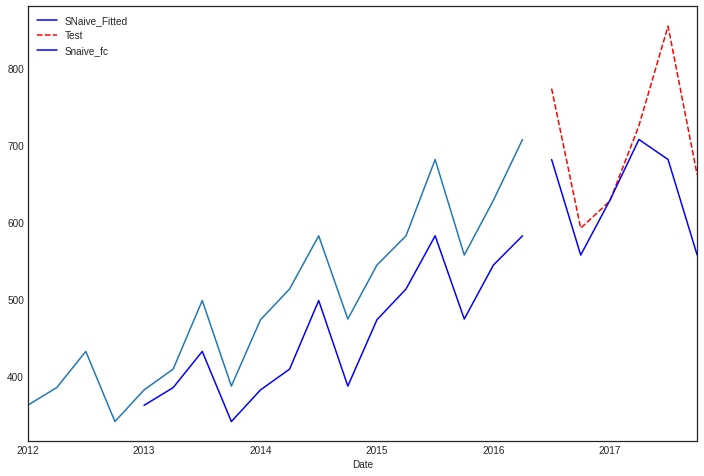

In [48]:
pd.plotting.register_matplotlib_converters()
train["Sales"].plot(figsize=(12,8))#, style="--", color="gray", legend=True, label="Train")
py_snaive_fit.plot(color="b", legend=True, label="SNaive_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["py_snaive"].plot(color="b", legend=True, label="Snaive_fc");


##### Model Evaluation:

In [49]:
#Training score
accuracy(train["Sales"].iloc[-len(py_snaive_fit.dropna()):], py_snaive_fit.dropna())

,RMSE,%MAPE
0,80.3,13.9


##### Model Accuracy

In [50]:
#Test score
accuracy(predictions["Sales"], predictions["py_snaive"])

,RMSE,%MAPE
0,92.0,9.4


##### Residual Check

In [51]:
# residcheck(py_snaive_resid.dropna(),12);


##### observations:

1. Seasonal naive forecast actually performs quite well considering it's just a logical forecasting method and there is no statistical procedure involved. 
2. Model captures seasonality and general trend quite well but under forecasts (underfitting)
3. Training RMSE is 80.3 and test RMSE is 92 which is less than the standard deviation of the training set (111).
4. Residual analysis shows residuls are not stationary and have non-zero mean. Residual plot clearly shows that the model hasn't extracted the trend and seasonal behaviour as well as we would like. Though visually the model seems to perform well, it's not a useful model **on its own**
5. Non-zero mean can be fixed by adding the mean back to the forecasts as explained [here](https://otexts.com/fpp2/residuals.html) but in this case the mean is significantly away from zero.
5. We could perhaps fit an AR model to the residuals to get more out of it. If you look at the ACF plot, it shows no lags are significant but the PACF plot (see below) shows 4,9,10,11,12 are significant. This is an AR process signature. Thus, if we want to capture information and make this model useful, we can fit an AR model to the residuals to create a 2 layer model
6. This shows importance of always checking the residuals after fitting the model

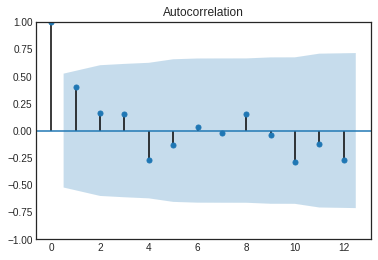

In [54]:
#PACF of Seasonal Snaive model residuals
plot_acf(py_snaive_resid);
# plot_pacf(py_snaive_resid);

### Triple Exponential Smoothing (Holt-Winter's Method)

Triple Exponential Smoothing (Holt Winter's method) decomposes the series into level, trend, seasonality. Future values are predicted by combining these systematic factors based on recent history. The intuitive idea here is that the future will behave very similar to recent past, we just have to find how much of the past is relevant. The three systematic components are:
   - **Level**, (alpha): Average value around which the series varies. For a seasonal time series, level is obtained by first de-seasonalizing the series and then averaging. Alpha value determines how much of the past to consider and is between [0,1]. alpha=1 means give importance only to the last data point (naive forecast)  
   - **Trend**, (beta): Trend is how the level changes over time. Similar to alpha, a beta value closer to 1 indicates the model is considering only the recent trend. Trend also has a damping factor (phi) which determines how much of the recent trend to 'forget'. Consider it as a de-rating factor on trend. 
   - **Seasonality** (gamma): This factor models how the series behaves in each time period for full season. Recall that in the previous blog about EDA (Part 1), I calculated the seasonal factors. Gamma is the same thing.
   
This method is called "Exponential" because each of the above factors give exponential weightage to the past values.

Additive model = (Level + Trend) + Seasonality

Multiplicative Model = (Level * Trend) * Seasonality

The `Exponentialsmoothing()` method in statsmodels finds the optimal alpha, beta, gamma and phi by minizing the errors.


![Trend and Seasonality](https://raw.githubusercontent.com/pawarbi/blog/master/images/ets.JPG "Trend & Seasonality")

#### Additive vs Multiplicative

Depending on the temporal structure of the time series, trend and seasonality can show additive, multiplicative or mix behaviour. 

In case of trend, if the time series has linear trend, it's additive. If it is exponentially increasing (power law), a multiplicative model might fit better. 

Seasonality is calculated relative to the level. If a series has additive seasonality, each season varies +/- relative to the level. E.g. in a quarterly series, in Q1 we might add +30 more units, -60 in Q2, +120 in Q3 and +60 in Q4 relative to level. Thus, seasonality peaks have somehwat fix height relative to level everywhere. On the other hand, in a multiplicative seasonality, the quantities will vary by %, i.e +5% in Q1, -7% in Q2, +10% in Q3 and +5 in Q4 relative to trend. As the level increases or decreases, seasonality can vary by %. 

For this time series, we identified during EDA (Part 1) that trend is exponential. Seasonality can be modeled as additive or multiplicatives. Note that we can turn a multiplicative component into additive by taking log or using power transform (BoxCox). This is often preferred and may perform better.

Refer to Part 1 where I calculated these seasonality factors. 

I replicated an illustration from Everette Gardener's [paper](https://www.bauer.uh.edu/gardner/docs/pdf/Exp-Sm-1985.pdf) to show this effect below. I highly recommend reading it if you are ineterested in exponential smoothing. 

![Trend and Seasonality](https://raw.githubusercontent.com/pawarbi/blog/master/images/trend-seas.JPG "Ref: https://www.bauer.uh.edu/gardner/docs/pdf/Exp-Sm-1985.pdf")

##### Grid Searching Triple Exponential Smoothing (Holt-Winter's Method)

Instead of fitting each model individually, I wrote a custom function `HWGrid()` to perform uniform, gridsearch using the model parameters. This function also returns statistics on residuals (Ljung Box test, Normality test and mean). You get model evaluation metric and residual metric for 24 models. This may take a while (5-15 min) on your computer. 

In [55]:
m=HWGrid(train["Sales"], test["Sales"], seasonal_periods=4)

ValueError: ignored

In [ ]:
m

Above resulting dataframe is sorted in ascending order showing model with lowest test RMSE and %MAPE at the top. Cells highlighted in green are the lowest numbers in their respective columns. Some observations from this result:

1. Train RMSE is much smaller than test RMSE, showing all the models perform far better on training set than test set
2. Models with additive trend and BoxCox=log are at the top. This confirms the finding from the EDA that the trend was more than linear. By taking the 'log', trend is linearized and thus "additive" model can be used. 
3. The top model ["add", "add", True, False] performed the worst on the train set. AICc is also the highest. 
4. Top 5 models have used 'log' transformation and generally have very similar performance on the test set. 
5. All models except one at the bottom as Uncorrelated residuals. Recall that model with uncorrelated residuals has captured as much information as it can from the available data. 
6. All models are biased (non-zero mean). Ideally we want the model to have zero mean but in this case the means are small and should be added to the forecast to correct the bias. 
7. All models have residuals that are normal. This is a useful but not necessary condition. Having a model with normal residuals can make prediction interval calculations easier. 
8. Model selection should always be done by comparing test evaluation metric and not by comparing residual diagnostic 
metrics.
9. Top and fourth model has high AICc. Third and fifth have almost same performance. We want to select a [**parsimonious**](https://stats.stackexchange.com/questions/17565/choosing-the-best-model-from-among-different-best-models) and **simple** model. I will select the model with additive seasonality and trend as it has the lowest AICc in the top 5 models.

In [ ]:
hw_model = ExponentialSmoothing(train["Sales"],
                          trend    ="add",
                          seasonal = "add", 
                          seasonal_periods=4, 
                          damped=False).fit(use_boxcox='log')

hw_fitted = hw_model.fittedvalues

hw_resid = hw_model.resid

#Adding the mean of the residuals to correct the bias.
py_hw = hw_model.forecast(len(test["Sales"])) + np.mean(hw_resid)

predictions["py_hw"] = py_hw

#Holt-Winter Parameters
hw_model.params_formatted

Note the optimized alpha, beta and gamma parameters.

   - alpha: 0.75, i.e 75% weight was given to the last observation
   
   - beta: learning parameter for trend. very small. Not much weight is given to the recent trend and trend is obatained from distant past
   
   - gamma: seasonal factor is 0. gamma is usually very small (<0.2) and we want it to be small. If the gamma is high, it can lead to overfitting becuase it means the model is learning too much from recent the recenet data. 0 here indicates seasonality is learned from the earliest season.

In [ ]:
#Plotting

train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
hw_fitted.plot(color="b", legend=True, label="HW_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["py_hw"].plot(color="b", legend=True, label="HW_Forecast");

##### Cross-Validation

In the above gridsearch, the training set size was fix and we evaluated the model performance by comparing train AICc, RMSE, %MAPE and test RMSE & %MAPE. Test metrics provides true forecast accuracy and should always be used for model selection. This is the preferred approach when the data size is large. But when the time series is short, cross-validation should be used to make sure the model does not overfit the data. The two common approaches are:

1. **Expanding window cross-validation**: We start with some initial training & test sets and with each iteration we add one observation to the training set. Forecast errors are calculated with each iteration and averaged to compare model performance. This simulates the performance of the model as we add more observations. For the final forecast we will using all the available history, so using expanding window gives us a good estimate of the forecast accuracy and uncertainty. 

2. **Rolling Window cross-validation**: Similar to Expanding but the training size remains same, instead it moves by one observation each time. Training and test lengths remain same.

Note that AICc, theoretically, provides the same information because it penalizes complex models that overfit.  

![cv](https://raw.githubusercontent.com/pawarbi/blog/master/images/Cv2.png "Cross-Validation Schemes")

In [ ]:
#I would like to perform 5 fold cross validation, want the training size to be at 
#least 12 and test window = forecast horizon 24 - 4 - 5 = 15. Initial training size should be min 12, max 15. 
#I will choose 15

hw_cv(data["Sales"], seasonal_periods=4, initial_train_window=15, test_window=4)


##### Residual Check

In [ ]:
residcheck(hw_resid, 12);

##### Accuracy


In [ ]:
accuracy(predictions.Sales,predictions["py_hw"] )

##### Observations:

1. In general, cross-validation shows that models with high AICc found in gridsearch have higher cv scores. 
2. Multiplicative trend models have high cv scores
3. The model I chose from the gridsearch (additive trend, seasonality and logged observations) has the lowest expanding cross-validation score. 
4. Plot shows that the model captures the trend, seasonality very well
5. This model predicts more sales than the actual (in test). From the gridsearch table, we see that the %MAPE is ~12%. Thus, if we use the this model, we should let the stakeholders know that the forecast error is +12%
6. Residuals are uncorrelated, normal, stationary with a bias (which we already corrected in the forecast)
7. Model performed better than seasonal naive approach.

### ETS

ETS standards for Error, Trend, Seasonality model (I have also seen some refer to it as **E**xponen**T**ial **S**moothing). It is similar to Holt-Winter's model above but with a State Space statistical framework. In HoltWinter's, the time series is decomposed into trend and seasonality and exponential weights are used to make the forecast. In a State Space approach, the underlying statistical process is identified and errors are factored in to make the forecast. Holt, Single Exponential Smoothing, Holt-Winter's, certain ARIMA models can all be categorised into ETS class models. 

ETS models follow a taxonomy of ETS(XYZ) where:
    
   - X:Error (aka innovations). It can be Additive (A) or Multiplicative (M)
   - Y:Trend. Trend component can be No trend (N), additive (A), Multiplicative (M) or damped (Ad)
   - Z:Seasonality, Null (N), additive (A) or multiplicative (M)
     
     
Thus, ETS(ANN) is an exponential model with additive error, no trend, no seasonality (i.e single exponential smoothing) and ETS(MAM) is analogous to Holt-Winter's method described above. There can be 24 different ETS models based on above combinations but not all combinations of ETS are stable, especially when error is multiplicative.

`statsmodels()` has a statespace implementation of exponential smoothing method in its `tsa.statespace()` [class](https://www.statsmodels.org/stable/statespace.html). It only has addditive error, additive & damped trend models for now (as of 4/20/2020). Recall that we can convert a multiplicative model into additive by power transform, so this is not a problem.

Using statespace (ETS) can often work better than Holt Winter because of how the parameters are initialized and optimized. This can make a huge difference in the results as we will see. ETS framework also returns 95% predictive interval which HW does not. 

Refer to [ch.7](https://otexts.com/fpp2/ets.html) of Hyndman's book for a quick refrence on ETS models and [this](https://robjhyndman.com/papers/hksg.pdf) for more detailed explanation.

For this series, we already know that trend is exponential so I will use logged version of the training set and model ETS(AAA) and ETS(AAdA)



#### ETS(A,Ad,A) model with Log

In [ ]:
#https://www.statsmodels.org/stable/statespace.html#
ets_LAdA=sm.tsa.statespace.ExponentialSmoothing(train_log,
                                           trend=True, 
                                           initialization_method= 'heuristic', 
                                           seasonal=4, 
                                           damped_trend=True).fit()

fc_LAdA = np.exp(ets_LAdA.forecast(6)) #inverting the Log

predictions["LAdA"]=fc_LAdA

In [ ]:
#Plotting

train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
np.exp(ets_LAdA.fittedvalues).plot(color="b", legend=True, label="Log-AAdA_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["LAdA"].plot(color="b", legend=True, label="Log-AAdA_Forecast");

##### Accuracy

In [ ]:
accuracy(predictions["Sales"],predictions["LAdA"])

##### Residual Check

In [ ]:
residcheck(ets_LAdA.resid,12);

##### Observations

1. ETS model performed significantly better than Holt-Winter's, despite the fact that they both perform exponential smoothing. RSME is 40.9 compared to 86 for HOlt Winter's. 
2. The primary reason why ETS performs better is the parameter initialization & optimization. Holt Winter's minimizes the residual error whereas ETS optimizes likelihood. ETS is more likely to obtain global minima faster & more accurately. This doesnt mean ETS will always be better, but in general it should perform better. 
3. Residuals are uncorrelated, normally distributed with 0 mean. 
4. The model struggled initially with a poor fit but it learned the systematic components very well and does an excellent job on the test set
5. Our observations from EDA and HW model informed the choice to take a log of the training set. In general, it's always a good idea to try log/BoxCox transform to stablize the variance.

#### ETS(A,Ad,A)

In [ ]:
ets_AAdA=sm.tsa.statespace.ExponentialSmoothing(train,
                                           trend=True, 
                                           initialization_method= 'concentrated', 
                                           seasonal=4, 
                                           damped_trend=True).fit()

fc_AAdA=ets_AAdA.forecast(len(test))

predictions["AAdA"]=fc_AAdA



In [ ]:
#Plotting

train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
ets_AAdA.fittedvalues.plot(color="b", legend=True, label="AAdA_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["AAdA"].plot(color="b", legend=True, label="AAdA_Forecast");

##### Accuracy

In [ ]:
accuracy(predictions["Sales"],predictions["AAdA"])

##### Residual Check

In [ ]:
residcheck(ets_AAdA.resid,12);

##### Observations:
1. (A,Ad,A) model without taking log also does very well, slightly worse than with log
2. Residuals are uncorrelated, look more normal than log version but are slightly biased (0.4 mean)
3. Fit looks better than logged model
4. Since we are using the damped model, notice how the trend has slowed down and Q3 forecast is lower than actual sales. This was the main reason I chose this model and the reason will be apparent later as we explore more models.

### SARIMA (Seasonal, Auto-Regressive, Integrated, Moving Average Model)

SARIMA (Seasonal ARIMA) is a classical, statistical forecasting method that predicts the forecast values based on past values, i.e lagged values (AR) and lagged errors (MA). Unlike Holt-Winter's (or ETS), it needs the time series to be stationary before it can be used. That's where the "Integrated" part comes from. "Integration" means differecning the series to remove trend and make it stationary. You can learn amore about the fundamentals by watching below video. Prof. Shmueli also has an excellent [book on Forecasting](http://www.forecastingbook.com/) that I highly recommend. 

I also recommend this free Coursera course [Practical Time Series Analysis](https://www.coursera.org/learn/practical-time-series-analysis) if you want to gain practical and intutitive understanding of ARIMA models. 

I will share my main take-aways from these and other resources I have used.  


> youtube: https://youtu.be/0xHf-SJ9Z9U

###### Auto-regression, AR(p):
1. As the name suggests, it's the linear regression with its past values
2. AR (p) => Current value = mean + fraction (phi) of yesterday's value + fraction (phi) of day before yesterday's value +......+ fraction of *pth* day's value + noise
3. If phi is negaitive => mean inversion, i.e today's value will likely go down after yesterday's peak. 
4. If phi is positive => Momentum
5. If phi = 0 => white noise
6. If phi = 1 => random walk
7. phi has to be between [-1,1] for process to be stationary
8. If the PACF plot cuts off sharply at lag k, while there is a gradual decay in ACF, it's a AR(p) process. [Note: I keep **P**ACF and AR(**P**) mnemonic in mind to know which plot to use for identifying AR process)
9. An AR(1) model is equivalent to MA(infinity) model, (practially q>>50)


Below video explain AR process really well
 

> youtube: https://youtu.be/5-2C4eO4cPQ

##### Moving Average ,MA(q):
1. MA process is ***not the same as*** taking moving average of a series
2. MA process is made up of white noise at different times. In MA(q), q tells us how far back along the sequence of white noise we have to loo for weighted average
3. For example, in our case if the series is an MA(q) process, the forecast is not affected by the previous sales but rather errors in past forecast. 
4. MA processes are not common but when combined with AR, can produce very accurate forecasts
5. For an MA(q) model, the forecast beyond 1 period will be the same for rest of the forecast horizon
6. To identify MA(q) process, plot the ACF. If it sharply cuts off at qth lag, it's an MA(q) process  


Thus, 
ARIMA (p,d,q) = constant + (weighted sum of last p values) + (weighted sum of last q values of forecast errors) after d differencing


Below are the simulated MA and AR processes. If you run this cell a few times and observe the plots, you will not that it's not possible to distinguish an AR from MA by just looking at the plots. You need to study the ACF & PACF to know the difference. 

In [ ]:
#Simulating AR process
from statsmodels.tsa.arima_process import ArmaProcess
ar = np.array([1,-0.9])
ma = np.array([1, 0.9])
AR = ArmaProcess(ar=ar, ma=None)
MA = ArmaProcess(ar=None, ma=ma)
simulated_AR= AR.generate_sample(125)
simulated_MA= MA.generate_sample(125)


fig, (ax1, ax2) = plt.subplots(1, 2)
# fig = plt.figure(figsize=(10,8))
fig.suptitle('Simulated AR & MA Processes')
ax1.plot(simulated_AR);
ax2.plot(simulated_MA);

Finding the parameters of the ARIMA process (p,d,q) is an art and science. Generally, p+q <=3. 
Similar to ARIMA, Seasonal ARIMA (SARIMA) has (P,D,Q) parameters, so SARIMA is (p,d,q)(P,D,Q). p+d+q+P+D+Q <=6 (generally)

Instead of finding the above parameters manually by studying the ACF, PACF, we usually use grid searching just like HW method above. `pmdarima` is a great library for SARIMA forecasting in Python. It returns the parameters that minimizes AICc and also has cross-validation tools.`statsmodels` has `arma_order_select_ic()` for identifying order of the ARMA model but not for SARIMA. 

Let's first take a look at the ACF and PACF to identify *potential* order of the SARIMA model

ACF plot shows that 1st lag is significant (outside the blue band), the ACFs and PACF both decrease gradually. We will need at least 1 differencing to make the series stationary. When ACF and PACF plots do not have sharp cut offs and significant lags at higher orders, its a indication of ARMA process with seasonality.

In [ ]:
plot_acf(train["Sales"]);
plot_pacf(train["Sales"]);

Using `pmdarima()` to find the SARIMA order with lowest aicc. This may take a few minutes to run. 

In [ ]:

(auto_arima(train["Sales"],
           seasonal=True,
           m=4,                          #seasonality_order 4
           d=1,                          #ACF plot showed we need at least 1 differencing
           information_criterion='aicc'). #You can choose AIC, BIC. AICc is corrected AIC
           summary())

###### Observations
`pmdarima()` has identified the training set as (0, 1, 1)x(1, 1, 0, 4) process. It's a seasonal AR(1) with d=D=1. 
Summary also shows that Ljung Box p value (Prob(Q) and JB p value (Prob(JB) are > 0.05 thus residuals are uncorrelated and normally distributed. Summary also shows MA is significant at lag 1, seasonal AR is significant at lag 4. 

In [ ]:
#Creating SARIMA model in Python using statsmodels

sarima_model=(SARIMAX(endog=train["Sales"], 
               order=(0,1,1),
               seasonal_order=(1,1,0,4),
               trend='c',
               enforce_invertibility=False))

sarima_fit=sarima_model.fit()

start = len(train)
end = len(train) +len(test) -1

sarima_fitted = sarima_fit.fittedvalues

sarima_resid = sarima_fit.resid

py_sarima = sarima_fit.predict(start, end, dynamic=False)

predictions["py_sarima"] = py_sarima

sarima_fit.plot_diagnostics();



##### Residual Check
`SARIMAX()` has its own residual diagnostics (shown above). It shows the residuals are normally distributed, uncorrelated. Q-Q plot shows an outlier in the lower left but otherwise everyting looks good.

##### Accuracy

In [ ]:
accuracy(predictions.Sales,py_sarima)

##### Observations:
1. SARIMA did worse than Holt-Winter's method. RMSE for HW was 85.7

##### SARIMA2 - (Using Logged value)

Recall that one of the observations from the HW method was log models performed better, so I will try log of the trainining set. The forecast will be logged values so I will inverse it with `np.exp()`

In [ ]:
#Fitting model to log of train

(auto_arima(np.log(train["Sales"]),
           seasonal=True,
           m=4,                           #seasonality_order 4
           information_criterion='aicc'). #You can choose AIC, BIC. AICc is corrected AIC
           summary())

It's a SARIMA model with no (p,d,q). (P,D,Q,m) = (1,1,0,4)

Prob(Q) > 0.05 and Prob(JB) > 0.05 Thus, residuals are uncorrelated and normal !

In [ ]:
sarima_logmodel=(SARIMAX(np.log(train["Sales"]), 
               order=(0,0,0),
               seasonal_order=(1,1,0,4),
               trend='c',
               enforce_invertibility=False)).fit()

sarima_log = np.exp(sarima_logmodel.predict(start, end))

predictions["sarima_log"] = sarima_log

slog_fitted = np.exp(sarima_logmodel.fittedvalues)


##### Residual Check

In [ ]:
sarima_logmodel.plot_diagnostics();

###### Observations

1. Residuals are not stationary but are normally distributed and are uncorrelated
2. There is an outlier in the left tail in the Q-Q plot. This is expected, since we took 1 seasonal differencing so model did not fit well to the early data. 

##### Accuracy

In [ ]:
accuracy(predictions.Sales,sarima_log )

RMSE & %MAPE are now slightly better than the HW model !!! Plot below shows model did not fit well in the early data but performs well on validation set.

In [ ]:
#Plotting

train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
slog_fitted.plot(color="b", legend=True, label="HW_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["sarima_log"].plot(color="b", legend=True, label="LogSARIMA_forecast");

>note: There is a misconception that ARIMA is a more accurate method that ETS/Holt-Winters. That's not accurate. In this example, ARIMA worked better but that may not always be the case and you won't know until you experiment. 

### Facebook Prophet

Facebook described Prophet library as below in their [documentation](https://facebook.github.io/prophet/):


" Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."

Video below gives great overview of this package.

>youtube: https://youtu.be/95-HMzxsghY

My main take aways are:
    
1. Prophet was built for high frequency data like daily, hourly, minute etc.. It may not work very well on monthly, quarterly data, but you won't know until you try. 
2. In addition to forecasting, it also provide changepoints, anomalies which are great for detecting sudden changes in the time series
3. Prof. Kourentzes [tested Prophet](https://kourentzes.com/forecasting/2017/07/29/benchmarking-facebooks-prophet/) along with other methods (ETS, SARIMA) on M3 competition data and found that Prophet performed poorly. 
4. ETS/HW & SARIMA cannot work with multiple seasonalities & high frequency data. Prophet can also include effect of holidays.  
5. Prophet requires the data to be in specific format. Dataframe must have time column `ds` and time series observations in column `y`
6. Though Prophet is designed mainly for high frequency data, it can be used for monthly/quarterly/yearly data with some tweaks.

In [ ]:
from fbprophet import Prophet

data_fb = data.reset_index()
data_fb.columns=['ds','y']   #create new df with columns ds & y
train_fb, test_fb = data_fb.iloc[:-len(test)], data_fb.iloc[-len(test):]   #create train & test df



In [ ]:
#Fit the model to train
fb1_model=Prophet(weekly_seasonality=False,
           daily_seasonality=False, 
           n_changepoints=10, 
           seasonality_mode="multiplicative").fit(train_fb) #I tried "additive too", it was slightly worse 

#Prophet results are saved to a dataframe using make_future_dataframe()
fb1_df=fb1_model.make_future_dataframe(6, freq='Q') #set the freq argument to 'Q' for quarterly data

#We only need "ds" and "yhat" columns.. "ds" is the date column and "yhat" are predictions

fb1_fc_df=fb1_model.predict(fb1_df)[["ds","yhat"]]

fb1_fc__=fb1_model.predict(fb1_df)

#Residuals
fb1_resid = train["Sales"].values - fb1_fc_df['yhat'].iloc[:len(train)]
fb1_fc = fb1_fc_df.iloc[-len(test):]

predictions["fb1"] = fb1_fc["yhat"].values



In [ ]:
fb1_fc_df.head()

##### Accuracy

In [ ]:

accuracy(test["Sales"],fb1_fc["yhat"].values)

Prophet performed significantly better than HW & SARIMA, that too on quarterly data ! I didn't expect that given how extensively it's been proven that Prophet does not work well on low frequency data. This is still not as good as the ETS models.

In [ ]:
train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fb1_fc_df.set_index('ds')["yhat"].iloc[:-len(test)].plot(color="b", legend=True, label="Prophet_Fitted")

predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")

fb1_fc_df.set_index('ds')["yhat"].iloc[-len(test):].plot(color="b", legend=True, label="Prophet_forecast");

Prophet has its own plotting method. As you can see the main drawback with this model is how wide the confidence interval is.

In [ ]:
fb1_model.plot(fb1_fc__);

In [ ]:
residcheck(fb1_resid,12);

##### Observations:

1. Prophet under forecasts while other methods were over the actual values in the validation set
2. Prophet captured the overall trend and seasonality well
3. Above plot also shows that Prophet overfitted the training set. I am sure there are hyperparameters that could be tuned but most the parameters are for high frequency data. Also, Prophet has a cross-validation method built-in, but it only accepts daily or sub-daily data. That's a limitation.
4. Residuals are uncorrelated but not-normal, which is ok. 
5. Uncertainty band is very wide.

### Forecasts

We evaluated four different forecasting methods:
   - Seasonal Naive
   - Holt-Winter's (Triple Exponential Smoothing)
   - ETS (Log-AAdA, AAdA)
   - SARIMA
   - Prophet

ETS gave the most accurate forecast, followed by Prophet..
Here's how the point forecasts compare with each other and the test set:



In [ ]:
predictions.round(0)

In [ ]:
forecasts = predictions.copy()
fc_melt=pd.melt(forecasts.reset_index(), 
        id_vars='Date', 
        value_vars=forecasts.columns,
        var_name="Model", 
        value_name="Forecasts").round(0)

fc_melt.head()

Interactive Chart

In [ ]:

#Ref:https://altair-viz.github.io/gallery/multiline_tooltip.html
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Date'], empty='none')

# The basic line
line = alt.Chart(fc_melt).mark_line(point=True).encode(
    x='Date',
    y=alt.Y('Forecasts:Q',scale=alt.Scale(domain=[500,1000], clamp=True)),
    color='Model:N',
    tooltip=['Date','Forecasts','Model']
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(fc_melt).mark_point().encode(
    x='Date',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', baseline='top', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Forecasts:Q', alt.value('              '))
)
text2 = line.mark_text(align='left', baseline='bottom', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Model:N', alt.value('    '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(fc_melt).mark_rule(color='gray').encode(
    x='Date',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text, text2
).properties(
    width=800, height=500, title="Comaprison of various Forecasting Models"
).interactive()

In the above chart, red line is the test set and rest are forecasts. You can zoom-in/out, pan to inspect the fit over the test set. 

1. SNaive & Prophet are below the test while SARIMA and HW are above. AAdA is also below actual in Q3.
2. HW & SARIMA are almost identical
3. If we had to pick a single best model, we would use the Log AAdA model which has the lowest RMSE and tracks the actual values very closely.
4. SARIMA did well on the test set but not so good on the early part of the training set. That's acceptable but the point is that all these methods did well in training or test. Thus, a better approach is to create an **ensemble forecast** that combines all or some of these forecasts together. 
5. Many research studies have shown that forecast combination often provides a more robust, accurate forecast that's less susceptible to overfitting. You can read more [here](https://repository.upenn.edu/cgi/viewcontent.cgi?article=1005&context=marketing_papers)


### Ensemble Forecasts

Although there are many different ways to combine forecasts, simple averaging often works as good as a more complex methods and is easier to implement/monitor/debug. As we saw above, some forecasts are above the test and some are below. So hopefully averaging will bring it closer to the actual values. 

We have 7 different models with more than 200 possible combinations. Let's compare their RSME with `fc_combo()` function I wrote. This function averages the forecasts and calculates the RSME.

>Note: This function uses `mean()` to average the forecasts but you should try `median()` as well. Depending on the data and the skewness, `meadian()` might work better in some cases.

In [ ]:
forecasts

In [ ]:
fc_combo(forecasts.iloc[:,1:])

##### Observations:
1. The best performing model is ('AAdA', 'sarima_log', 'fb1') with RMSE = 33.3 which is better than the best solo model LogAAdA (RSME:40) but not by very much. 
2. Notice how some of the individual models that gave very poor forecasts (Seasonal Naive, HW, SARIMA) but when combined with other forecasts, performed very well. Similarly the models that performed the best LogAAdA, SARIMA_Log did not create the best combination forecast.
3. Diversity of models in forecast combination makes the forecast more robust, typically produce normally distributed errors and narrower prediction intervals. Follow the research work by [Prof. Kourentzes](https://kourentzes.com/forecasting/) for theory and practical advise on forecast combination.
4. More models in combination does not mean better results. When selecting combinations, focus should be on divertsity of the models selected (different class of models). Some researchers (Armstrong et al) have suggested using 5 models. 
5. This shows the value of experimentation in any statistical /Machine Learning project. 

### Final Model

For the final model, we use all the data and not just the training set. If we want a single best model we will choose the Log ETS(A,Ad,A). The best combination model is ('AAdA', 'sarima_log', 'fb1') which has the lowest RMSE. The difference between them is not significant when accuracy is compared. In the next blog, I am going to demonstrate how to deploy this forecasting model in PowerBI & AzureML so to keep things simple, I will use the Log ETS(A,Ad,A) model. Also, ETS allows simulations which can be used for [aggregate forecasting](https://otexts.com/fpp2/aggregates.html) and communicating uncertainty. Forecast combination is a fascinating topic and deserves a seperate blog post. 

##### ETS Model

In [ ]:
ets_model=sm.tsa.statespace.ExponentialSmoothing(np.log(data),
                                           trend=True, 
                                           initialization_method= 'heuristic', 
                                           seasonal=4, 
                                           damped_trend=True).fit()

results = ets_model.get_forecast(4)

results_df=results.summary_frame(alpha=0.05).apply(np.exp)[["mean","mean_ci_lower","mean_ci_upper"]]
results_df.round(1)

In [ ]:
fig, ax = plt.subplots()
results_df['mean'].plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(results_df.index, results_df['mean_ci_lower'],
                results_df['mean_ci_upper'], alpha=0.2, color='gray')

data["Sales"].plot(legend=True, label="Data", figsize=(12,8));

#### Forecast Uncertainty

Forecasts are based on history and are probabilistic. When creating and communicating the forecasts, it is important that the stakeholders who will be using the forecasts understand the uncertainty in the estimates. Forecasts have [four sources](https://robjhyndman.com/hyndsight/narrow-pi/) of uncertainties:
1. Random error
2. Parameters used in the model
3. Model choice
4. Data uncertainty

While it's not possible to estimate all sources of uncertainties, the forecaster should provide enough information/tools to the stakeholders to understand and gauge the risk in using the forecast. Stochastic simulation can be used for risk modeling. 



##### Simulation

Imagine that the stakeholders are interested in the aggregate sales for 2018, i.e the total sales and not just the quarterly sales. The obvious way is to calculate quarterly forecasts, like we did, and then summing them up to get annual sales. While this may provide a good estimate, it will not be correct. Since the quarterly forecasts are distributions, we need to account for the variance in those distributions when calculating the aggregates. If the forecasts were based on median or percentile, we cannot simply add them up. Also, it's possible that not all forecasts are from normal distributions and thus cannot be added. 

Monte Carlo simulation can be used to overcome these challenges. Below we will generate 5000 future forecasts based on the ETS model we have and then calculate the aggregates, prediction intervals and cumulative distribution function for it.

In [ ]:
#Simulating 5000 futures
sim_frame=ets_model.simulate(4, 
                   anchor='2018-03-31',
                   repetitions=5000 ).T.reset_index().iloc[:,2:].apply(np.exp).round(1)

sim_frame["aggregate"] = sim_frame.sum(axis=1)

sim_frame.tail()

In [ ]:
mean_2018_sales = np.mean(sim_frame["aggregate"])
print("25th percntile Sales for FY2018:",np.quantile(sim_frame["aggregate"], 0.25).round(0))
print("\nAvg Sales for FY2018, Simulation:",mean_2018_sales.round(0))
print("\n75th percntile Sales for FY2018:",np.quantile(sim_frame["aggregate"], 0.75).round(0))

print("\nFY2018 Based on Quarterly Forecasts:",results_df["mean"].sum().round(0))

As you can see, if we just summed up the quarterly forecasts, the aggregate for 2018 would be 3157, and if we used the simulations it would be 3163. In this case the difference is not much and is within the forecast error but that may not always be the case. 

When communicating forecasts (or any other uncertainty), providing range is a better solution than providing point estimates. e.g. we calculated the 25% & 75% percentile for the aggregate forecast. Thus, we could say that we are 50% confident that the FY2018 sales would be between 3083 and 3240.i.e P50 [3083 , 3240]. This can also be interpreted as there is only 25% chance that Sales would be >3240 next year. This conveys the uncertainty far better than point estimates.

##### Confidence Interval vs. Prediction Interval

It's common to calculate and show 95% confidence around the mean forecast. 95% is a conventional measure and doesn't have any particular significance. Confidence interval (CI)is not the same as prediction interval (PI). CI is often confused as a measure of uncertainty and is used to show the upper and lower bound for the estimate - **it's not!**

Confidence interval is around the populatio point estimate. e.g. if we calculate the mean, to convey the *error* in calculating it we compute the CI. In our case the mean for Q1 is 692.5 and lower and upper CI bound are [599.8,799.5]. We are 95% confident that the mean will be within this bound. This **doesn't** say the forecast will be between these bounds with 95% confidence. Think of CI as error around the population point estimate because of limited sample size. CI will be lower if increase the sample size or lower the alpha. Point estimate means calculating a single number e.g. mean, median, percentile etc. about the population/sample. Also make a note if the CI is calculated using parameters of the models (residuals).

To calculate the upper and lower bound on the forecast, we need prediction interval. PI can be calculated using the forecast errors or simulations. PI gives us the upper and lower bounds based on the model we have created. By definition PI > CI. In our examle, the 97.5th percentile is 923 and 2.5% percentils is 691. Now we can be 95% confident that the forecast for Q1 2018 will be between 923 and 691 !

Many years ago at the end of my Business Simulations class in grad school, [Prof.Nelson](https://www.mccormick.northwestern.edu/research-faculty/directory/profiles/nelson-barry.html) said the main take-away from his class should be the difference between PI and CI and correct use/interpretation of CI. I hope after reading this blog, among other things, you will also learn to interprete CI correctly, especially in the context of forecasting. CI is useless for forecasting.  

In [ ]:
q1_975=np.quantile(sim_frame.iloc[:,1],0.975)
q1_025=np.quantile(sim_frame.iloc[:,1],0.025)

print("PI_95%:", q1_95.round(1))
print("PI_5%:", q1_05.round(1))

##### Cumulative Distribution Function

In [ ]:
#Reference: http://stanford.edu/~raejoon/blog/2017/05/16/python-recipes-for-cdfs.html

num_bins = 100
counts, bin_edges = np.histogram (sim_frame["aggregate"], bins=num_bins, normed=True)
cdf = np.cumsum (counts)
cdf_x = bin_edges[1:]
cdf_y = cdf/cdf[-1]
cdf_df = pd.DataFrame({'Sales':cdf_x, 'Percentile':cdf_y})
cdf_df.head()

In [ ]:
#collapse-hide
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Sales'], empty='none')

# The basic line
line = alt.Chart(cdf_df).mark_line(interpolate='basis').encode(
    x='Sales:Q',
    y='Percentile:Q', tooltip = ["Sales", "Percentile"])


# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(cdf_df).mark_point().encode(
    x='Sales:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text1 = line.mark_text(align='left', baseline="bottom",dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Percentile:Q', alt.value(' '))
)

text2 = line.mark_text(align='left', baseline="top", dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Sales:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(cdf_df).mark_rule(color='gray').encode(
    x='Sales:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text1, text2
).properties(
    width=600, height=300, title ="FY2018 Sales Probability "
).configure_axis(grid=False)

This is a dynamic and interactive way for the stakeholders to understand forecast uncertainty. For example, if this French retailer has a Revenue target at least 3300, they have only 12% (1-0.88)  chance of achiveing that based on this forecating model. The stakeholders will find this more beneficial for decision making than the typical static forecast chart. You could create similar chart for all quarters and make it more interactive. Power BI can be used for that.

### Forecast Using R

Import rpy2

Use `pandas2ri.activate()` to convert pandas to R dataframe

`%load_ext rpy2.ipython` to use %%R magic command to run R in a cell

In [ ]:
import rpy2

import warnings
warnings.filterwarnings('ignore')

from rpy2.robjects import pandas2ri
import rpy2.rinterface as rinterface
pandas2ri.activate()

%load_ext rpy2.ipython

#### R-ETS

`ets()` package in R uses a state space approach rather than Holt-Winter's (which can be modeled in ETS form). You can read more [here](https://otexts.com/fpp2/ets-forecasting.html)

In [ ]:
%%R -i data -o fets,fc_ets

library(fpp2)

r_train <- ts(data$Sales, start=c(2012,01), frequency=4)

fets <- r_train %>% ets()

fc_ets<-r_train %>% ets() %>% forecast(h=4) %>% summary()

r_train %>% ets() %>% forecast(h=4) %>% autoplot()

In [ ]:
print(fets,end="")

`ets()` returned ETS(M,A,M) as the best model based on  AICc, i.e "multiplicative" error, "additive" trend and "multiplicative" error. We also obtained same results in Python. But because we used a log transform the multiplicative term became additive.

In [ ]:
fc_ets

#### R-SARIMA

In [ ]:
%%R -i train -o fsarima

r_train <- ts(train$Sales, start=c(2012,01), frequency=4)

fsarima <- r_train %>% auto.arima(stepwise=FALSE) 





In [ ]:
%%R -i data -o fc_arima

r_data <- ts(data$Sales, start=c(2012,01), frequency=4)


fc_arima<- r_data %>% auto.arima(stepwise=FALSE) %>% forecast(h=4) %>% summary()

r_data %>% auto.arima(stepwise=FALSE) %>% forecast(h=4) %>% autoplot()



In [ ]:
print(fsarima, end="")

We obtained the same SARIMA order as Python ARIMA(0,1,0)(1,1,0)[4]

### Conclusion

We explored various time series forecasting methods, model selection procedures and created an ensemble forecast that can be used to improve the forecast accuracy. We also briefly covered communicating uncertainty in forecasts. I did not include any deep-learning methods as they generally do well on  large dataset with multiple features. Classical methods such as HW/ETS & ARIMA provide more interpretable results which can prove useful for understanding the behaviour of the time time series and make business decisions. In the next blog I will cover deploying this model in PowerBI.  


### References:

   1. Forecasting: Principles and Practice, by Prof. Hyndman
   2. Time Series Analysis and its Applications, by Robert Shumway
   3. Time Series Analysis and Forecasting, by Montgomery  & Jennings
   4. Introduction to Time Series and Analysis, by Brockwell
   5. Practial Time Series Forecasting with R, by Galit Shmueli   6. https://homepage.univie.ac.at/robert.kunst/pres09_prog_turyna_hrdina.pdf